# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import zscore
from datetime import datetime

# Dataframe

## Read .csv and create dataframe

In [2]:
file_path = 'Le Wagon Solar Data v2.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Select only relevant columns from .csv
selected_columns = ['meter_id', 'tstamp', 'impwh', 'expwh', 'ptot']
new_df = df[selected_columns]

In [3]:
weather_path1 = 'Weather_Data_2.csv'
weather_path2 = 'Station_Square_6508.csv'

weather_df1 = pd.read_csv(weather_path1)
weather_df2 = pd.read_csv(weather_path2)
weather_df3 = weather_df1.append(weather_df2, ignore_index=True)

weather_df = pd.DataFrame(weather_df3)
weather_df['PeriodEnd'] = pd.to_datetime(weather_df['PeriodEnd']).dt.tz_convert(None)

weather_df.rename(columns={'PeriodEnd': 'tstamp'}, inplace=True)

/tmp/ipykernel_20396/2715497583.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_df3 = weather_df1.append(weather_df2, ignore_index=True)


## Format dataframe

In [4]:
new_df['ptot'] = new_df['ptot'].abs()
# Convert the object column to datetime
new_df['tstamp'] = pd.to_datetime(new_df['tstamp'])

# Set the timestamp column as the DataFrame index
new_df.set_index('tstamp', inplace=True)

/tmp/ipykernel_20396/2568583737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ptot'] = new_df['ptot'].abs()
/tmp/ipykernel_20396/2568583737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tstamp'] = pd.to_datetime(new_df['tstamp'])


In [5]:
# Resample with a frequency of 5 minute and fill gaps with 0
resample_df = []

for meter_id in new_df['meter_id'].unique():
    # Filter the DataFrame for the current meter ID
    meter_df = new_df[new_df['meter_id'] == meter_id]

    # Resample with a frequency of 5 minutes and fill gaps with 0
    resampled_df = meter_df.resample('5T').sum().fillna(0)

    # Store the resampled DataFrame in the list
    resample_df.append(resampled_df)

df_final = pd.concat(resample_df)

# Remove specific rows at beginning of df
start_timestamp = pd.Timestamp('2020-11-28 08:25')
end_timestamp = pd.Timestamp('2020-11-28 23:55')

# Create a boolean mask to filter rows between the start and end timestamps
mask = (df_final.index < start_timestamp) | (df_final.index > end_timestamp)

# Apply the mask to the DataFrame to remove rows between the two timestamps
df_f = df_final[mask]

In [6]:
df_f['meter_id'] = df_f['meter_id'].replace(0, method='ffill')

/tmp/ipykernel_20396/772608358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['meter_id'] = df_f['meter_id'].replace(0, method='ffill')


In [7]:
mask = (df_f['meter_id'] == 5884) 
filtered_df = df_f.loc[mask].copy()

In [8]:
# Filter for summer months (November, December, January, February)
df_summer = df_f[(df_f.index.month.isin([11, 12, 1, 2])) & 
                 (df_f.index.time >= pd.to_datetime('05:00:00').time()) & 
                 (df_f.index.time <= pd.to_datetime('20:00:00').time())]

# Filter for spring and autumn (March, April, September, October)
df_aut_spring = df_f[(df_f.index.month.isin([3, 4, 9, 10])) & 
                 (df_f.index.time >= pd.to_datetime('06:00:00').time()) & 
                 (df_f.index.time <= pd.to_datetime('19:00:00').time())]

# Filter for winter months (May, June, July, August)
df_winter = df_f[(df_f.index.month.isin([5, 6, 7, 8])) & 
                 (df_f.index.time >= pd.to_datetime('06:30:00').time()) & 
                 (df_f.index.time <= pd.to_datetime('18:30:00').time())]

# Combine the DataFrames for summer, autumn, and winter
df_f = pd.concat([df_summer, df_aut_spring, df_winter])
df_f

,meter_id,impwh,expwh,ptot
tstamp,,,,
2020-11-29 05:00:00,5884,59.68,1.183848e+09,0.000
2020-11-29 05:05:00,5884,59.68,1.183848e+09,0.000
2020-11-29 05:10:00,5884,59.68,1.183848e+09,0.000
2020-11-29 05:15:00,5884,59.68,1.183848e+09,0.000
2020-11-29 05:20:00,5884,59.68,1.183848e+09,0.000
...,...,...,...,...
2022-07-23 07:30:00,6508,127407.20,1.942778e+09,22.726
2022-07-23 07:35:00,6508,127407.20,1.942780e+09,25.098
2022-07-23 07:40:00,6508,127407.20,1.942782e+09,26.645


## Create a label column for Power Loss Events

In [9]:
def power_loss(row):
    power_loss_values = []
    consecutive_zeros = 0
    
    for value in row:
        if value == 0:
            consecutive_zeros = consecutive_zeros + 1 # Count consecutive zeros
        #value in ptot column is non-zero
        else:
            #check the count is between 2 and 4.5 hours 
            if consecutive_zeros < 24 or consecutive_zeros > 54:
                #add 1 to the list and extend the number of entries per the count
                power_loss_values.extend([2] * consecutive_zeros)
            else:
                #add 2 to the list and extend the number of entries per the count
                power_loss_values.extend([1] * consecutive_zeros)
            
            power_loss_values.append(0) #Append 0 to indicate the end of consecutive zeros
            consecutive_zeros = 0       #Reset the count if a non-zero value is encountered

    #If the last value in 'ptot' is zero, extend 'Power Loss' with 2s or 1s based on the count
    if consecutive_zeros > 0:
        if consecutive_zeros < 24 or consecutive_zeros > 54:
            power_loss_values.extend([2] * consecutive_zeros)
        else:
            power_loss_values.extend([1] * consecutive_zeros)

    return power_loss_values #Convert the list to an int by summing its elements

df_f['Power Loss Event'] = power_loss(df_f['ptot'].to_list())

In [10]:
df_f

,meter_id,impwh,expwh,ptot,Power Loss Event
tstamp,,,,,
2020-11-29 05:00:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:05:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:10:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:15:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:20:00,5884,59.68,1.183848e+09,0.000,2
...,...,...,...,...,...
2022-07-23 07:30:00,6508,127407.20,1.942778e+09,22.726,0
2022-07-23 07:35:00,6508,127407.20,1.942780e+09,25.098,0
2022-07-23 07:40:00,6508,127407.20,1.942782e+09,26.645,0


In [11]:
selected_meter_id = 6508
start_timestamp = '2022-07-22 15:00:00'
end_timestamp = '2022-07-23 08:00:00'

# Filter the DataFrame based on the specified conditions
selected_data = df_f[(df_f['meter_id'] == selected_meter_id) & 
                    (df_f.index >= start_timestamp) & 
                    (df_f.index < end_timestamp)]

selected_data.head(60)

,meter_id,impwh,expwh,ptot,Power Loss Event
tstamp,,,,,
2022-07-22 15:00:00,6508,127274.40,1.942594e+09,125.948,0
2022-07-22 15:05:00,6508,127274.40,1.942610e+09,191.113,0
2022-07-22 15:10:00,6508,127274.40,1.942625e+09,180.630,0
2022-07-22 15:15:00,6508,127274.40,1.942640e+09,171.264,0
2022-07-22 15:20:00,6508,127274.40,1.942652e+09,151.503,0
2022-07-22 15:25:00,6508,127274.40,1.942664e+09,135.909,0
2022-07-22 15:30:00,6508,127274.40,1.942674e+09,124.905,0
2022-07-22 15:35:00,6508,127274.40,1.942682e+09,97.223,0
2022-07-22 15:40:00,6508,127274.40,1.942692e+09,114.787,0


In [12]:
# Create a new column 'expkWh' by dividing 'expwh' by 1000
#df_f['expkWh'] = df_f['expwh'] / 1000

year_to_extract = 2023
month_to_extract = 5  # May

one_year_data = df_f.loc[df_f.index.year == year_to_extract]
month_data = df_f.loc[(df_f.index.year == year_to_extract) & (df_f.index.month == month_to_extract)]

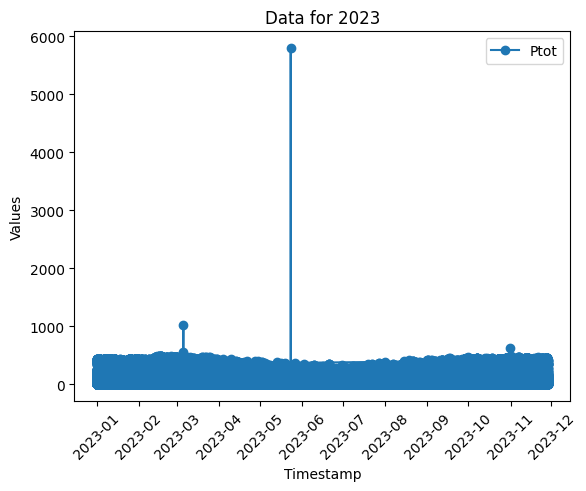

In [13]:
# Plotting
#plt.plot(month_data.index, month_data['ptot'], label='Ptot', marker='o')
plt.plot(one_year_data.index, one_year_data['ptot'], label='Ptot', marker='o')

plt.title(f'Data for {year_to_extract}')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.legend()  # Show legend for better interpretation

# Show the plot
plt.show()

In [14]:
month_data = df_f.loc[(df_f.index.year == year_to_extract) & (df_f.index.month == month_to_extract)]
    
# Calculate the mean value for 'ptot' in the specified month
mean_value = month_data['ptot'].mean()

mean_value

74.484190063033

In [15]:
def replace_outliers(df, year, month):
    
    # Extract data for the specified year and month
    specific_month_data = df.loc[(df.index.year == year) & (df.index.month == month)]

    # Calculate the mean value for 'ptot' in the specified month
    mean_value = specific_month_data['ptot'].mean()

    # Identify values 30% higher than the mean
    outliers = specific_month_data['ptot'] > 6 * mean_value

    # Replace outliers with the mean value
    specific_month_data.loc[outliers, 'ptot'] = mean_value

    return specific_month_data

In [16]:
def clean_data_for_year_range(df, start_year, end_year):
    
    cleaned_df = df.copy()
    
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):  # Iterate over all months
            cleaned_df.loc[(cleaned_df.index.year == year) & (cleaned_df.index.month == month)] = replace_outliers(df, year, month)

    return cleaned_df

In [17]:
# Clean data for the years 2020 to 2023
cleaned_data = clean_data_for_year_range(df_f, start_year=2020, end_year=2023)

In [18]:
cleaned_data

,meter_id,impwh,expwh,ptot,Power Loss Event
tstamp,,,,,
2020-11-29 05:00:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:05:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:10:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:15:00,5884,59.68,1.183848e+09,0.000,2
2020-11-29 05:20:00,5884,59.68,1.183848e+09,0.000,2
...,...,...,...,...,...
2022-07-23 07:30:00,6508,127407.20,1.942778e+09,22.726,0
2022-07-23 07:35:00,6508,127407.20,1.942780e+09,25.098,0
2022-07-23 07:40:00,6508,127407.20,1.942782e+09,26.645,0


In [19]:
start_timestamp = '2022-01-01 09:00:00'
end_timestamp = '2022-01-01 14:00:00'

# Filter the DataFrame between the specified timestamps
selected_data = cleaned_data.loc[start_timestamp:end_timestamp]
selected_data.head(60)

,meter_id,impwh,expwh,ptot,Power Loss Event
tstamp,,,,,
2022-01-01 09:00:00,5884,70.24,2.177479e+09,65.290,0
2022-01-01 09:05:00,5884,70.24,2.177487e+09,97.215,0
2022-01-01 09:10:00,5884,70.24,2.177501e+09,160.228,0
2022-01-01 09:15:00,5884,70.24,2.177522e+09,261.728,0
2022-01-01 09:20:00,5884,70.24,2.177536e+09,159.903,0
2022-01-01 09:25:00,5884,70.24,2.177545e+09,110.700,0
2022-01-01 09:30:00,5884,70.24,2.177554e+09,109.937,0
2022-01-01 09:35:00,5884,70.24,2.177561e+09,80.378,0
2022-01-01 09:40:00,5884,70.24,2.177568e+09,91.684,0


In [20]:
# Choose a specific year, month, and week
chosen_year = 2023
chosen_month = 1  
chosen_week = 1

# Extract data for the chosen year and month
chosen_month_data = cleaned_data[(cleaned_data.index.year == chosen_year) & 
                                 (cleaned_data.index.month == chosen_month)]

# Extract data for the chosen week
start_date = chosen_month_data.index.min() + pd.DateOffset(weeks=chosen_week - 1)
end_date = start_date + pd.DateOffset(weeks=1)
chosen_week_data = chosen_month_data[(chosen_month_data.index >= start_date) & 
                                     (chosen_month_data.index < end_date)]

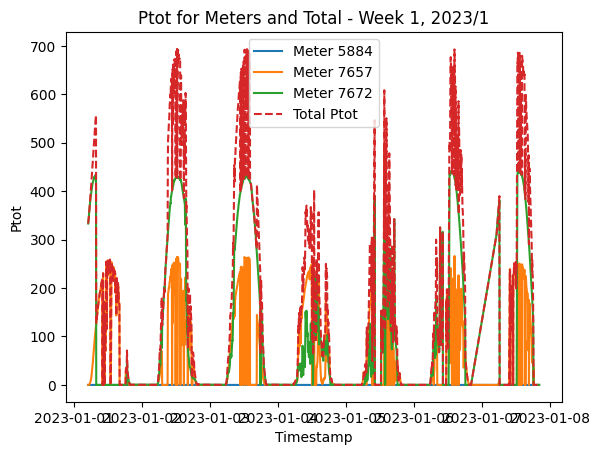

In [21]:
# Separate plots for each meter
for meter_id, meter_data in chosen_week_data.groupby('meter_id'):
    plt.plot(meter_data.index, meter_data['ptot'], label=f'Meter {meter_id}')

# Total 'ptot' plot
total_ptot = chosen_week_data.groupby(chosen_week_data.index)['ptot'].sum()
plt.plot(total_ptot.index, total_ptot, label='Total Ptot', linestyle='dashed')

# Customize the plot
plt.title(f'Ptot for Meters and Total - Week {chosen_week}, {chosen_year}/{chosen_month}')
plt.xlabel('Timestamp')
plt.ylabel('Ptot')
plt.legend()
plt.show()

In [22]:
final_df = pd.merge(cleaned_data, weather_df, on=['tstamp', 'meter_id'], how='left')

In [23]:
nan_values = final_df.isnull()
# Count the number of NaN values in each column
nan_count_per_column = nan_values.sum()

In [24]:
# Assuming your DataFrame is named 'df'
# Create a boolean mask for NaN values
nan_mask = pd.isnull(final_df)

# Get the indices (row and column) where NaN values are present
nan_indices = np.where(nan_mask)

# Display the indices
print("Indices of NaN values:")
print(nan_indices)

Indices of NaN values:
(array([], dtype=int64), array([], dtype=int64))


In [25]:
project_df = final_df.dropna(axis=0, how='all').drop(columns='PeriodStart')

In [26]:
project_df=project_df.sort_values(by=['meter_id','tstamp'])

In [27]:
project_df.to_csv('solar_project_data.csv', index=False)

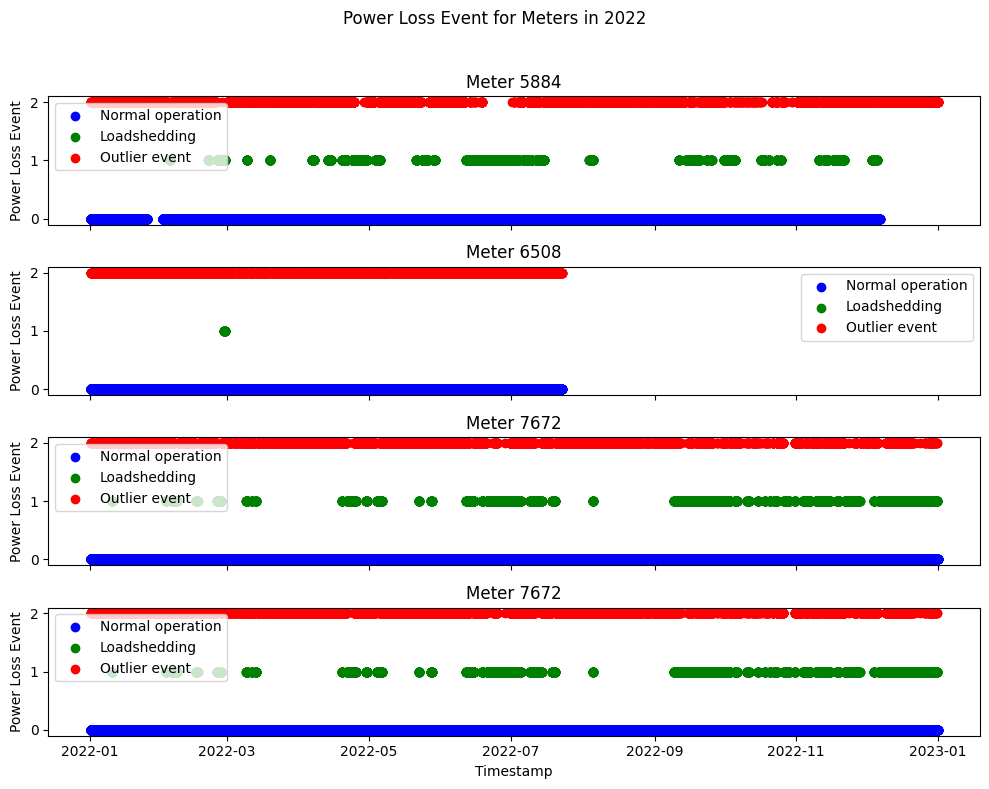

In [28]:
# Filter DataFrame for only the year 2022
project_df = project_df[(project_df['tstamp'] >= '2022-01-01') & (project_df['tstamp'] < '2023-01-01')]

# Define the meter ids for plotting
meter_ids_to_plot = [5884, 6508, 7672, 7672]

# Create subplots
fig, axes = plt.subplots(nrows=len(meter_ids_to_plot), figsize=(10, 8), sharex=True)

# Plot each meter on a separate subplot
for i, meter_id in enumerate(meter_ids_to_plot):
    df_meter = project_df[project_df['meter_id'] == meter_id]
    colors = ['blue', 'green', 'red']  # Colors for Power Loss Event 0, 1, and 2
    
    for event_value, color in zip([0, 1, 2], colors):
        df_event = df_meter[df_meter['Power Loss Event'] == event_value]
        
        # Assign labels based on event values
        event_label = {0: 'Normal operation', 1: 'Loadshedding', 2: 'Outlier event'}.get(event_value, f'Event {event_value}')
        
        axes[i].scatter(df_event['tstamp'], df_event['Power Loss Event'], label=event_label, color=color)

    axes[i].set_title(f'Meter {meter_id}')
    axes[i].set_ylabel('Power Loss Event')
    axes[i].legend()

# Add labels, title, and legend
axes[-1].set_xlabel('Timestamp')
plt.suptitle('Power Loss Event for Meters in 2022')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout to accommodate suptitle
plt.show()

/tmp/ipykernel_20396/902357428.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Power Loss Event Label', data=df_2022, palette={'Normal operation': 'blue', 'Loadshedding': 'red', 'Outlier event': 'green'})


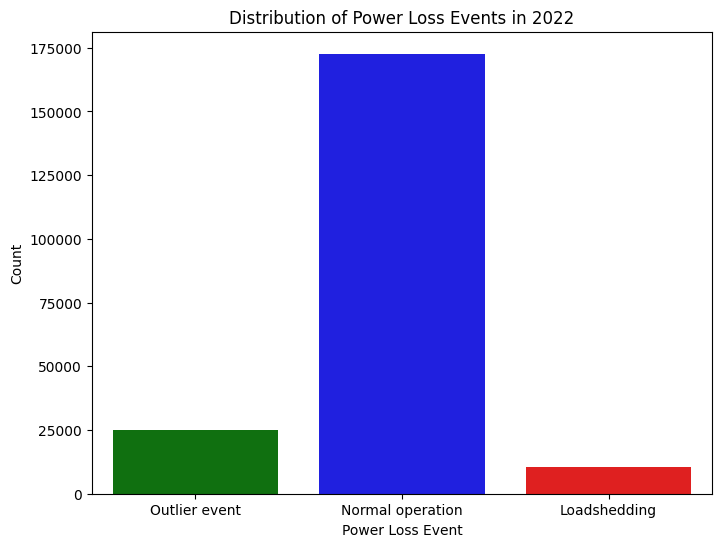

In [29]:
# Filter DataFrame for only the year 2022
df_2022 = project_df[(project_df['tstamp'] >= '2022-01-01') & (project_df['tstamp'] < '2023-01-01')]

# Map numerical labels to meaningful labels
label_mapping = {0: 'Normal operation', 1: 'Loadshedding', 2: 'Outlier event'}
df_2022['Power Loss Event Label'] = df_2022['Power Loss Event'].map(label_mapping)

# Plot a bar plot for Power Loss Event
plt.figure(figsize=(8, 6))
sns.countplot(x='Power Loss Event Label', data=df_2022, palette={'Normal operation': 'blue', 'Loadshedding': 'red', 'Outlier event': 'green'})
plt.title('Distribution of Power Loss Events in 2022')
plt.xlabel('Power Loss Event')
plt.ylabel('Count')
plt.show()